## Armaan Kapoor

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delimiter=";")

df.columns = [
    "fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
    "quality",
]

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler() # z = (x - u) / s
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Removing redundant features, ranked by multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
"""
The variance inflation factor is a measure for the increase of the
variance of the parameter estimates if an additional variable, given by
exog_idx is added to the linear regression. It is a measure for
multicollinearity of the design matrix, exog.
"""

X_scaled_const = sm.add_constant(X_train_scaled)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_scaled_const, i + 1) for i in range(X.shape[1])]
print(vif)


                Variable       VIF
0          fixed_acidity  7.304978
1       volatile_acidity  1.835649
2            citric_acid  3.163611
3         residual_sugar  1.780600
4              chlorides  1.478310
5    free_sulfur_dioxide  2.019755
6   total_sulfur_dioxide  2.237680
7                density  5.960791
8                     pH  3.262345
9              sulphates  1.430921
10               alcohol  2.939139


In [ ]:
# Drop 'fixed_acidity' and 'density' to reduce multicollinearity
X = df.drop(['quality', 'fixed_acidity', 'density'], axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_const = sm.add_constant(X_train_scaled)
X_test_scaled_const = sm.add_constant(X_test_scaled)

model = sm.OLS(y_train, X_train_scaled_const).fit()
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     75.13
Date:                Thu, 23 May 2024   Prob (F-statistic):          2.81e-111
Time:                        18:42:52   Log-Likelihood:                -1266.8
No. Observations:                1279   AIC:                             2554.
Df Residuals:                    1269   BIC:                             2605.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6239      0.018    307.513      0.000       5.588       5.660
x1            -0.1761      0.024     -7.457      0.000      -0.222      -0.130
x2            -0.0142      0.027     -0.520      0.603      -0.068       0.039
x3             0.0040      0.019      0.208      0.835      -0.033       0.041
x4            -0.0944      0.022     -4.368      0.000      -0.137      -0.052
x5             0.0605      0.026      2.370      0.018       0.010       0.111
x6            -0.1266      0.026     -4.868      0.000      -0.178      -0.076
x7            -0.0792      0.023     -3.405      0.001      -0.125      -0.034
x8             0.1453      0.021      6.815      0.000       0.103       0.187
x9             0.3048      0.021     14.600      0.000       0.264       0.346
==============================================================================
Omnibus:                       26.693   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.022
Skew:                          -0.183   Prob(JB):                     7.50e-10
Kurtosis:                       3.809   Cond. No.                         3.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_train_scaled_const, i + 1) for i in range(X.shape[1])]
print(vif)

               Variable       VIF
0      volatile_acidity  1.667796
1           citric_acid  2.218335
2        residual_sugar  1.084757
3             chlorides  1.396176
4   free_sulfur_dioxide  1.951655
5  total_sulfur_dioxide  2.020818
6                    pH  1.617529
7             sulphates  1.359617
8               alcohol  1.303011


### What do we know so far:

#### Significant Predictors:
- **Intercept**: 5.6239 (p < 0.000)
- **volatile_acidity**: -0.1794 (p < 0.000)
- **chlorides**: -0.0891 (p < 0.000)
- **free_sulfur_dioxide**: 0.0580 (p = 0.025)
- **total_sulfur_dioxide**: -0.1200 (p < 0.000)
- **sulphates**: 0.1468 (p < 0.000)
- **alcohol**: 0.2966 (p < 0.000)

#### Residual Diagnostics:
- **Durbin-Watson**: 2.003
- **Omnibus test**: 28.708 (p < 0.000)
- **Jarque-Bera**: 46.050 (p < 0.000)

#### Multicollinearity (VIF):
- **High VIF**:
  - `fixed_acidity`: 7.37
  - `density`: 6.02

### Interpretation:
- Model explains 34.8% of variance in `quality`.
- High multicollinearity in `fixed_acidity` and `density`.

Multicollinearity can be attributed to two relationships. 

1. `fixed_acidity` and `volatile_acidity` are related. 

2. `density` is inversely correlated with `alcohol` (% abv). 

Notably: Alcohol (% abv) has the largest absolute correlation with quality. Pearson 0.5.

Organic compounds that evaporate easily -> `volatile_acidity`. 

In the red wine data set, pearson correlation between volatile acidity and fixed_acidity is high. 


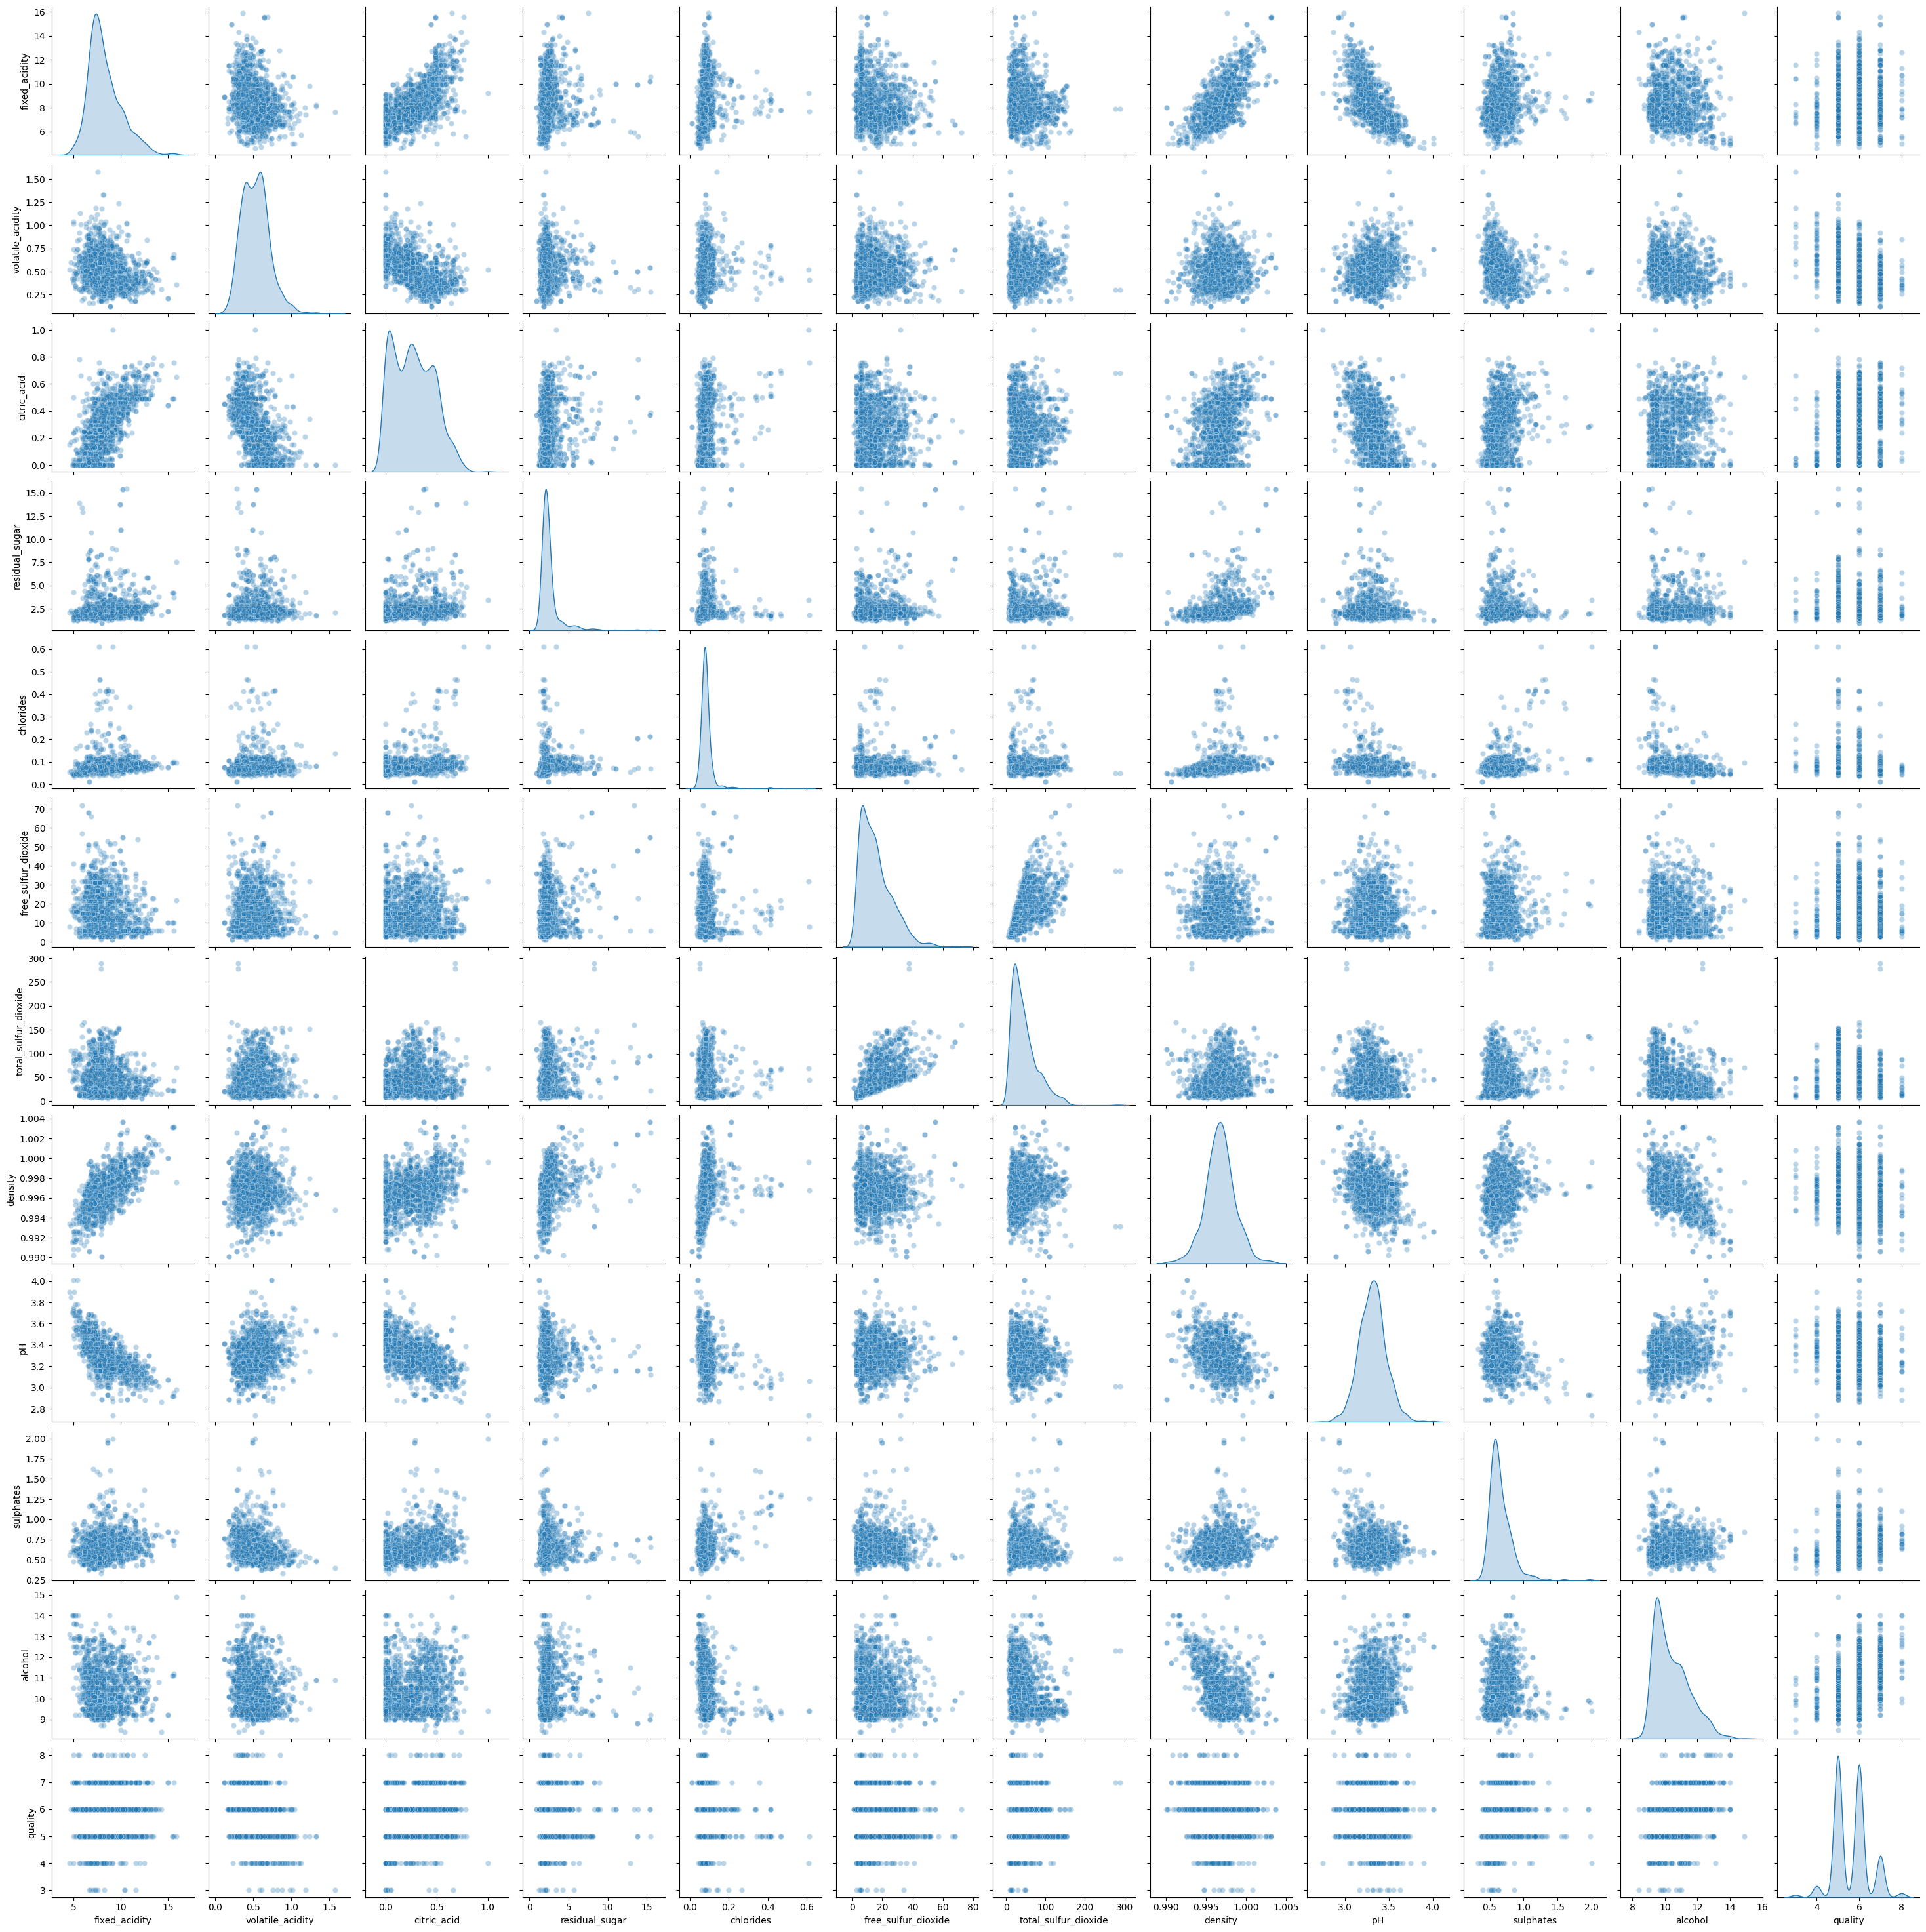

In [ ]:
df['quality'] = y
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha':0.3})
plt.show()

# Next

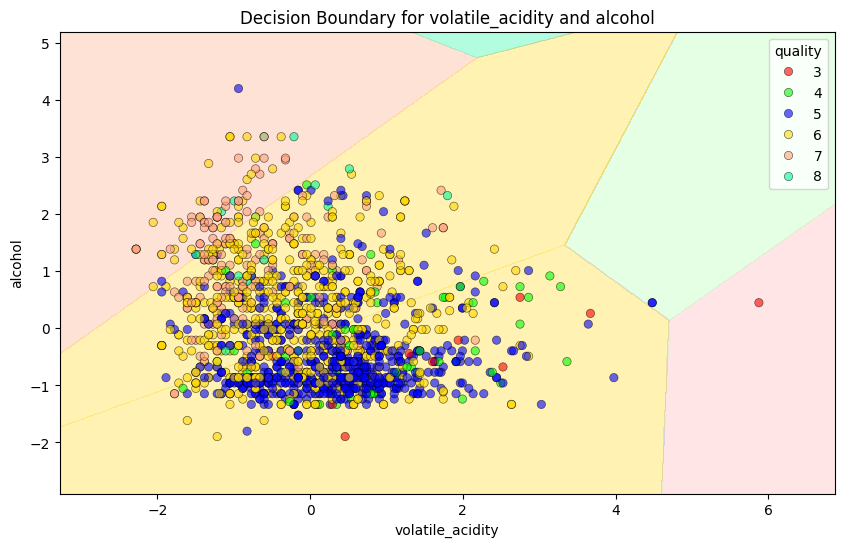

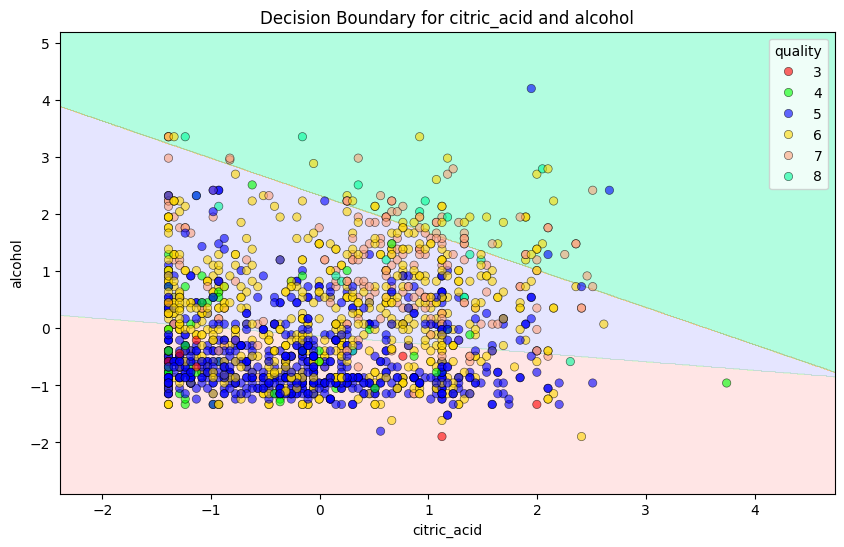

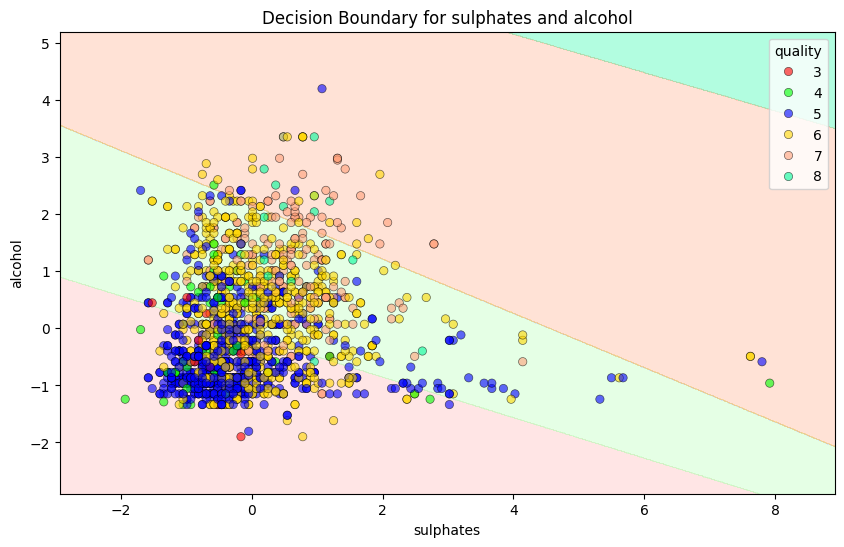

In [ ]:


pairs = [
    ("volatile_acidity", "alcohol"),
    ("citric_acid", "alcohol"),
    ("sulphates", "alcohol"),
]

cmap_light = ListedColormap(
    ["#FFAAAA", "#AAFFAA", "#AAAAFF", "#FFD700", "#FFA07A", "#00FA9A"]
)
cmap_bold = ["#FF0000", "#00FF00", "#0000FF", "#FFD700", "#FFA07A", "#00FA9A"]

for feature_x, feature_y in pairs:
    X = df[[feature_x, feature_y]]
    y = df["quality"]

    # Train Logistic Regression classifier using lbfgs solver for 1e3 iters
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
    clf.fit(X, y)

    # Plot decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    sns.scatterplot(
        x=X[:, 0], y=X[:, 1], hue=y, palette=cmap_bold, alpha=0.6, edgecolor="k"
    )
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f"Decision Boundary for {feature_x} and {feature_y}")
    plt.show()

# Decision Trees and Random Forrests 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as pltÍ
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [ ]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delimiter=";")

df.columns = [
    "fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
    "quality",
]

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

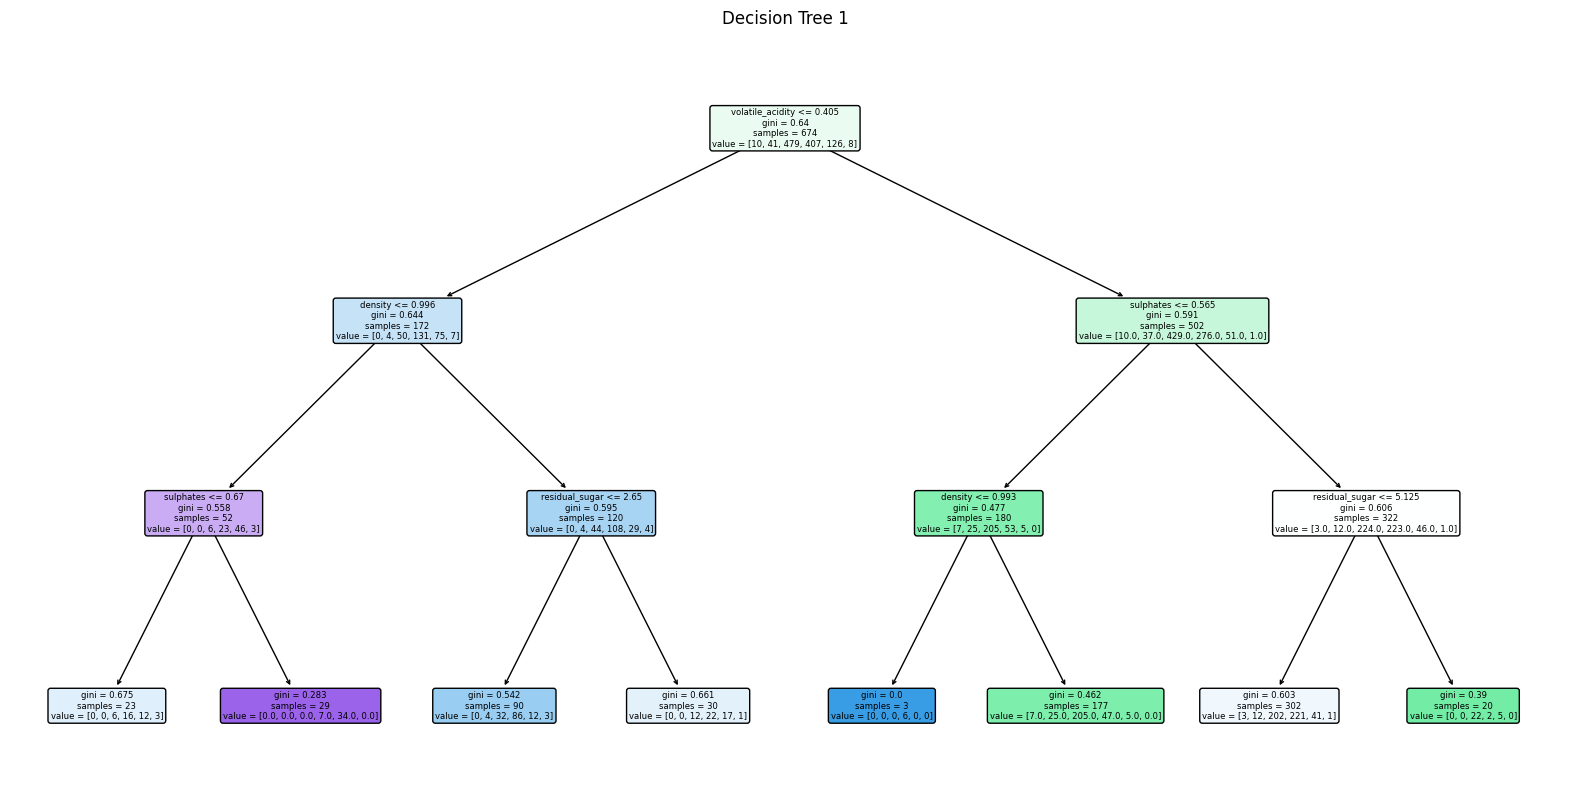

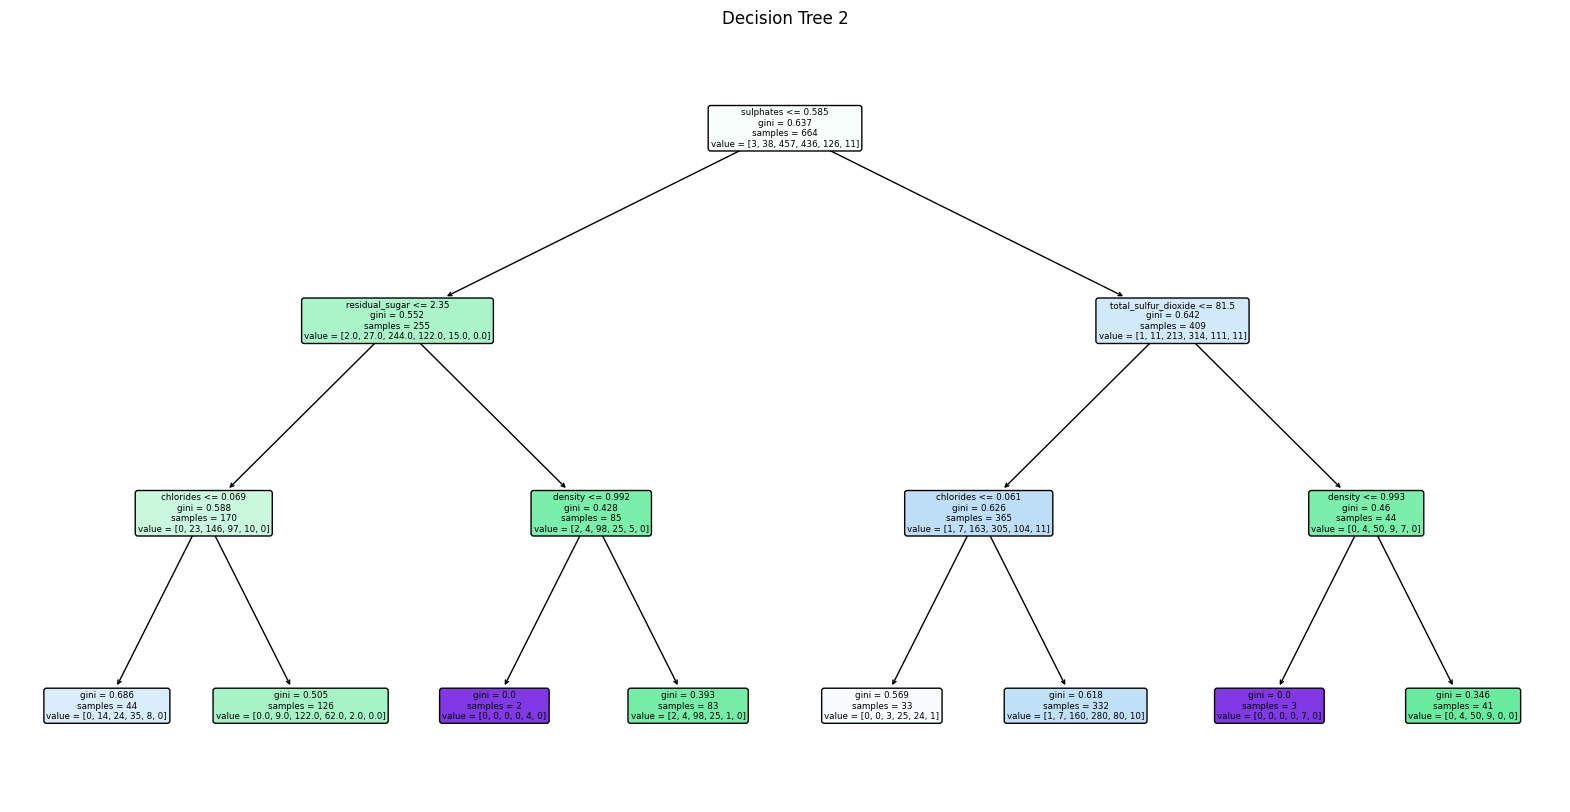

In [ ]:
# Random Forest Cassifier
rf = RandomForestClassifier(n_estimators=7, max_depth=3)
rf.fit(X_train, y_train)

num_trees = 2
for i in range(num_trees):
    plt.figure(figsize=(20, 10))
    plot_tree(rf.estimators_[i], feature_names=X_train.columns, filled=True, rounded=True)
    plt.title(f"Decision Tree {i+1}")
    plt.show()


In [ ]:
# Larger RFC
rf = RandomForestClassifier(n_estimators=20, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0)
print(f"Test Accuracy: {accuracy:.4f}")
print("Test Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Test Accuracy: 0.6402
Test Confusion Matrix:
[[  0   0   0   2   0   0]
 [  0   1  11   7   0   0]
 [  0   0 167  47   3   0]
 [  0   0  53 139  21   0]
 [  0   0   2  37  30   1]
 [  0   0   0   1   5   1]]
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.05      0.10        19
           5       0.72      0.77      0.74       217
           6       0.60      0.65      0.62       213
           7       0.51      0.43      0.47        70
           8       0.50      0.14      0.22         7

    accuracy                           0.64       528
   macro avg       0.55      0.34      0.36       528
weighted avg       0.65      0.64      0.62       528



In [ ]:

y_pred_train = rf.predict(X_train)
accuracy_all = accuracy_score(y_train, y_pred_train)
conf_matrix_all = confusion_matrix(y_train, y_pred_train)
class_report_all = classification_report(y_train, y_pred_train, zero_division=0)

print(f"Train Accuracy: {accuracy_all:.4f}")
print("Train Confusion Matrix:")
print(conf_matrix_all)
print("Train Classification Report:")
print(class_report_all)

Train Accuracy: 0.9897
Train Confusion Matrix:
[[  8   0   0   0   0   0]
 [  0  34   0   0   0   0]
 [  0   0 462   2   0   0]
 [  0   0   3 421   1   0]
 [  0   0   1   3 125   0]
 [  0   0   0   0   1  10]]
Train Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        34
           5       0.99      1.00      0.99       464
           6       0.99      0.99      0.99       425
           7       0.98      0.97      0.98       129
           8       1.00      0.91      0.95        11

    accuracy                           0.99      1071
   macro avg       0.99      0.98      0.99      1071
weighted avg       0.99      0.99      0.99      1071



In [ ]:
# Predictions on the entire dataset
y_pred_all = rf.predict(X)

print("ENTIRE DATASET: All Red Wine Datapoints\n\n")
accuracy_all = accuracy_score(y, y_pred_all)
conf_matrix_all = confusion_matrix(y, y_pred_all)
class_report_all = classification_report(y, y_pred_all, zero_division=0)

print(f"Overall Accuracy: {accuracy_all:.4f}")
print("Overall Confusion Matrix:")
print(conf_matrix_all)
print("Overall Classification Report:")
print(class_report_all)

ENTIRE DATASET: All Red Wine Datapoints


Overall Accuracy: 0.8743
Overall Confusion Matrix:
[[  8   0   0   2   0   0]
 [  0  35  11   7   0   0]
 [  0   0 629  49   3   0]
 [  0   0  56 560  22   0]
 [  0   0   3  40 155   1]
 [  0   0   0   1   6  11]]
Overall Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.80      0.89        10
           4       1.00      0.66      0.80        53
           5       0.90      0.92      0.91       681
           6       0.85      0.88      0.86       638
           7       0.83      0.78      0.81       199
           8       0.92      0.61      0.73        18

    accuracy                           0.87      1599
   macro avg       0.92      0.78      0.83      1599
weighted avg       0.88      0.87      0.87      1599



In [ ]:
#this is a random comment